In [2]:
import open3d as o3d
import glob
from pydicom import dcmread
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from rsna_dataloader import *

DATA_BASEPATH = "../data/rsna-2024-lumbar-spine-degenerative-classification/"
TRAINING_DATA = retrieve_coordinate_training_data(DATA_BASEPATH)

df = TRAINING_DATA.dropna()
# This drops any subjects with nans

filtered_df = pd.DataFrame(columns=df.columns)
for series_desc in CONDITIONS.keys():
    subset = df[df['series_description'] == series_desc]
    if series_desc == "Sagittal T2/STIR":
        subset = subset[subset.groupby(["study_id"]).transform('size') == 5]
    else:
        subset = subset[subset.groupby(["study_id"]).transform('size') == 10]
    filtered_df = pd.concat([filtered_df, subset])

filtered_df = filtered_df[filtered_df.groupby(["study_id"]).transform('size') == 25]

series_descs = {e[0]: e[1] for e in df[["series_id", "series_description"]].drop_duplicates().values}

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [4]:
coords = pd.read_csv("../data/SpineNet/coords_3d.csv")
coords

,study_id,level,x,y,z
0,4003253,L1,2.192236,57.393290,-373.897314
1,4003253,L2,2.417129,55.910159,-405.982332
2,4003253,L3,2.663579,53.663727,-441.036977
3,4003253,L4,2.900401,54.755404,-475.276522
4,4003253,L5,-1.697765,63.999043,-505.892668
...,...,...,...,...,...
11844,4290709089,L2,1.119082,47.663407,-359.280225
11845,4290709089,L3,0.473506,40.302511,-394.637869
11846,4290709089,L4,-0.206997,39.813034,-429.821794
11847,4290709089,L5,-0.924925,46.765941,-464.796865


In [5]:
bounding_boxes = pd.read_csv("../data/SpineNet/bounding_boxes_3d.csv")
bounding_boxes

,study_id,level,x_min,y_min,z_min,x_max,y_max,z_max
0,4003253,l1_L2,-31.883112,55.910159,-407.471932,36.492477,88.325627,-372.407714
1,4003253,l2_L3,-35.661464,53.663727,-443.292351,40.742172,90.443165,-403.726958
2,4003253,l3_L4,-31.962392,53.663727,-476.185770,37.526372,86.210547,-440.127730
3,4003253,l4_L5,-27.926512,54.755404,-515.759729,29.129148,85.962923,-465.409462
4,4003253,l5_S1,-34.051310,63.999043,-550.395336,30.824358,107.574225,-488.962227
...,...,...,...,...,...,...,...,...
9670,4290709089,l1_L2,-38.349206,47.663407,-370.018624,41.191947,92.640617,-314.318392
9671,4290709089,l2_L3,-35.297229,40.302511,-401.536769,36.889816,79.418562,-352.381325
9672,4290709089,l3_L4,-38.933257,39.813034,-430.488903,39.199766,75.480191,-393.970761
9673,4290709089,l4_L5,-33.948271,39.813034,-471.026245,32.816350,76.109183,-423.592414


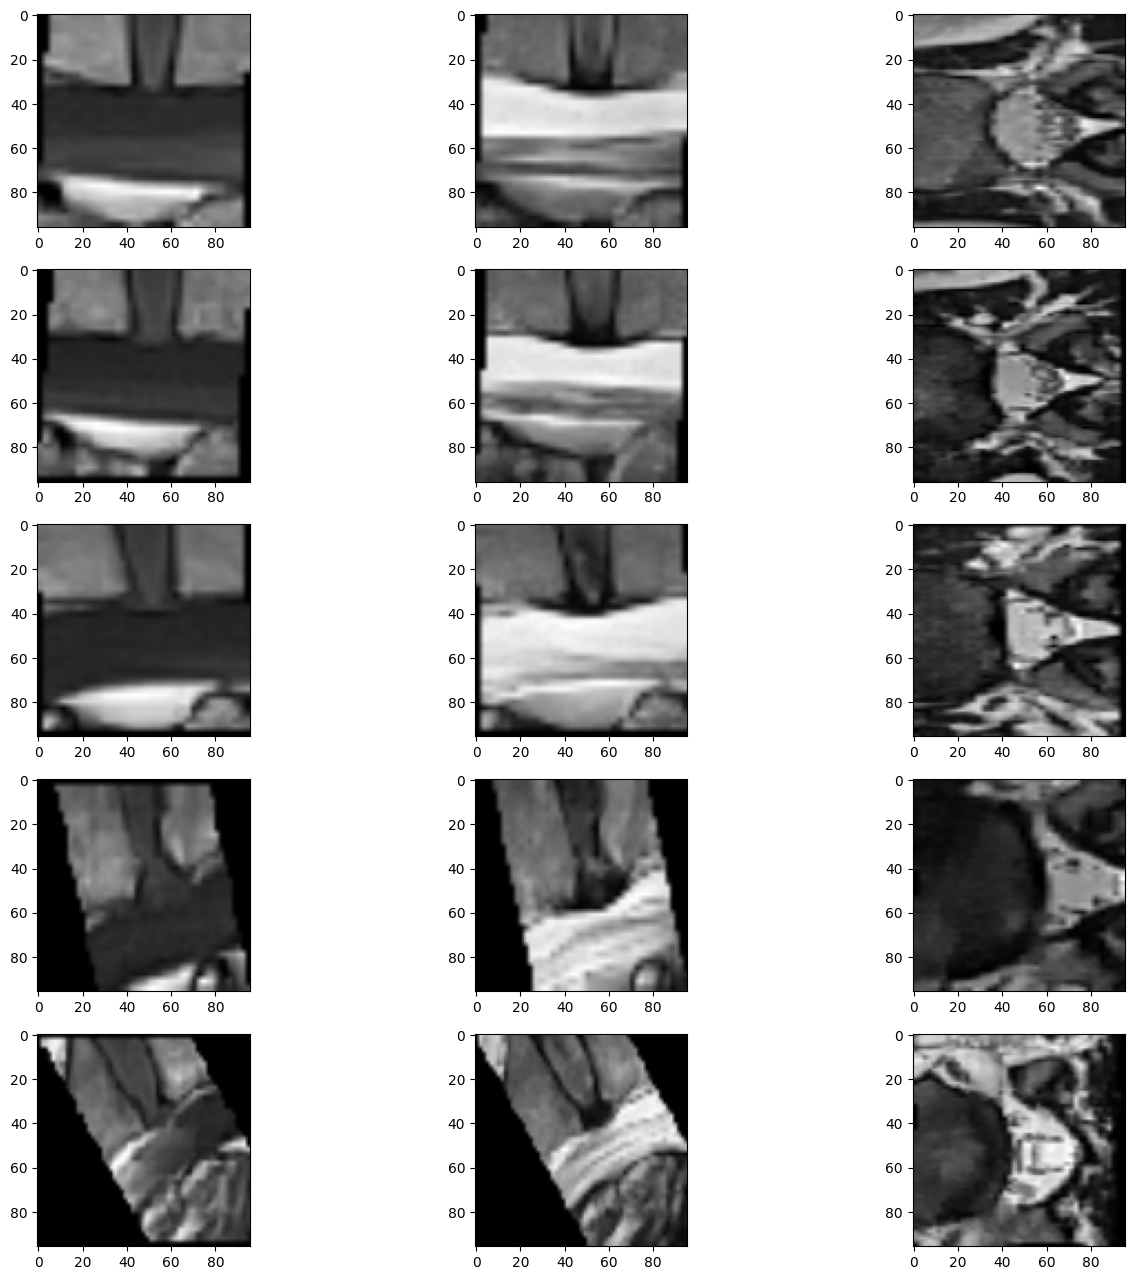

KeyboardInterrupt: 

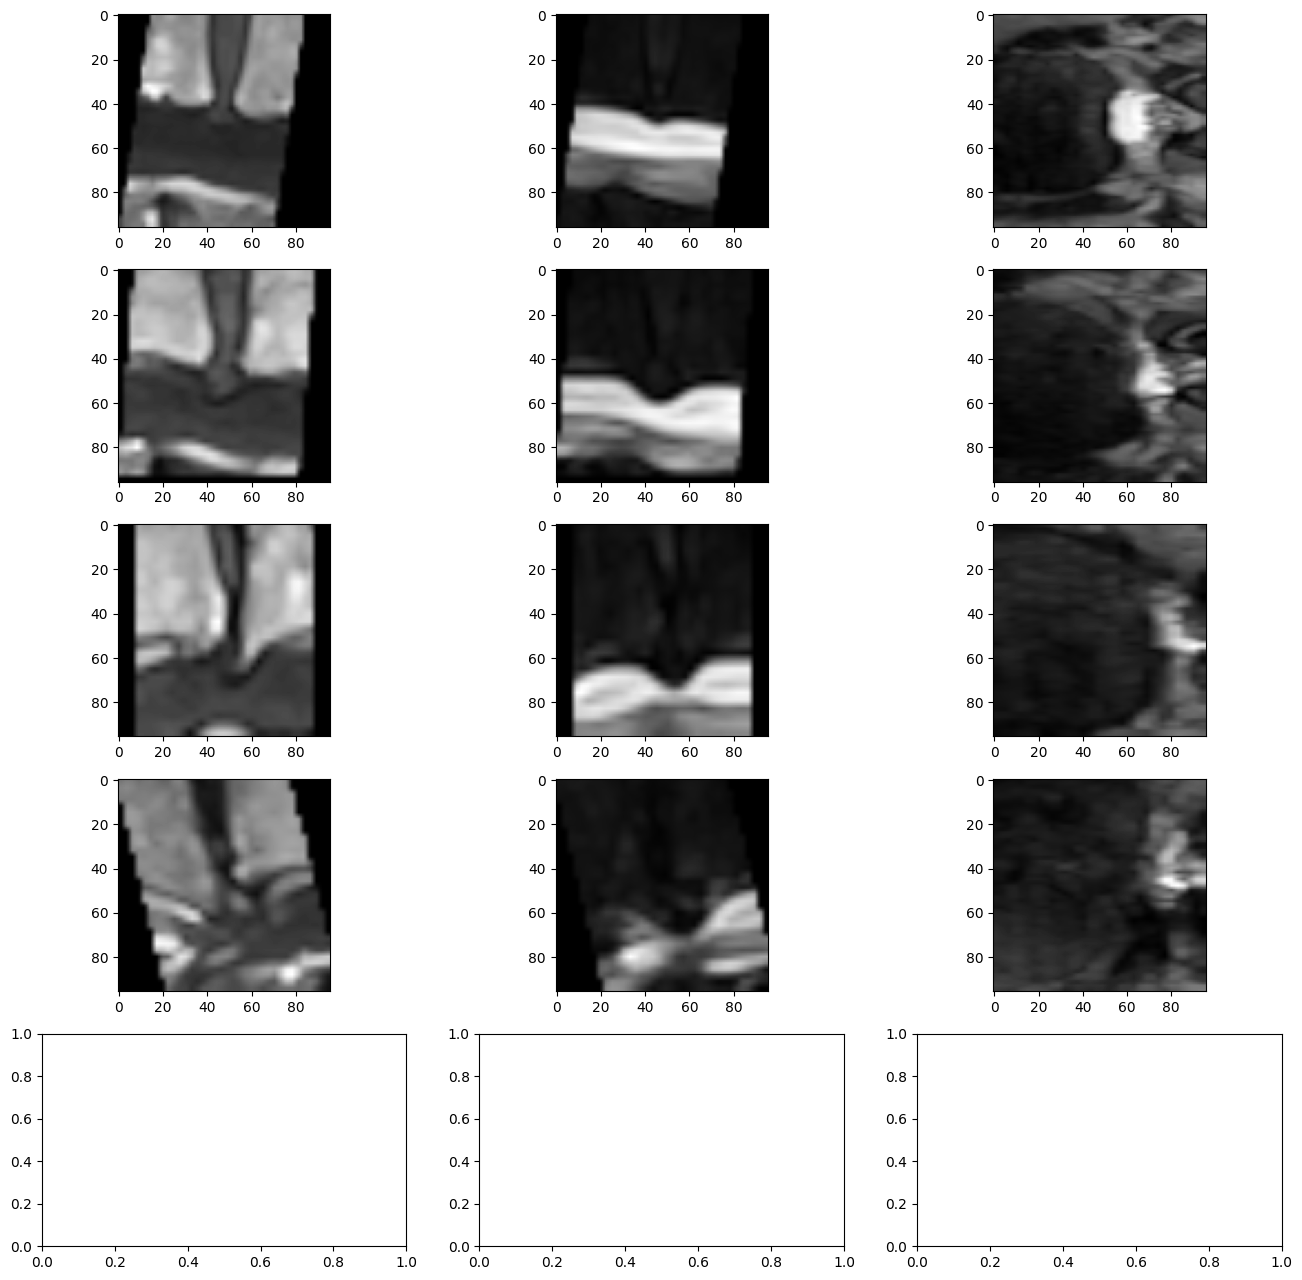

In [6]:

for index in range(10):
    f, axs = plt.subplots(5, 3, figsize=(16,16))

    for i in range(index * 5, (index + 1) * 5):
        row = bounding_boxes.iloc[i]
        level = row['level'].replace("/", "").lower()
        min_bound = np.array([row['x_min'], row['y_min'], row['z_min']])
        max_bound = np.array([row['x_max'], row['y_max'], row['z_max']])
    
        row_1 = coords.iloc[i + index]
        row_2 = coords.iloc[i + index + 1]
    
        #level = (row_1['level'].str + "_" + row_2["level"].str).lower()
        pt1 = np.array([row_1['x'], row_1['y'], row_1['z']])
        pt2 = np.array([row_2['x'], row_2['y'], row_2['z']])
        
        grid = read_vertebral_level_as_voxel_grid_nonaligned(
            f"../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/{row_1['study_id']}",
            vertebral_level=level,
            center_point_pair=(pt1,pt2),
            vx_size=1,
            min_bound=min_bound,
            max_bound=max_bound,
            series_type_dict=series_descs,
            voxel_size=(96, 96, 96),
            caching=False
        )
        
        # grid = tf(grid.astype(np.float32))
        
        axs[i % 5, 0].imshow(grid[0, 48], cmap="gray")
        axs[i % 5, 1].imshow(grid[2, 48], cmap="gray")
        axs[i % 5, 2].imshow(grid[1, :, :, 48], cmap="gray")
        
    plt.show()

In [ ]:
tf = tio.Compose([
    tio.RescaleIntensity((0, 1)),
    tio.RandomAffine(translation=(10,10,10), 
                     degrees=(25,25,25), 
                     isotropic=True,
                     image_interpolation="linear", 
                     p=1, 
                     default_pad_value="otsu"),
    tio.RandomNoise(p=1),
    tio.RandomSpike(1, intensity=(-0.5, 0.5), p=1),
    tio.RandomBlur(std=(0, 2), p=1),
])


In [ ]:
f, axs = plt.subplots(5, 3, figsize=(12,12))

index = 0
for i in range(index * 5, (index + 1) * 5):
    row = bounding_boxes.iloc[i]
    level = row['level'].replace("/", "").lower()
    min_bound = np.array([row['x_min'], row['y_min'], row['z_min']])
    max_bound = np.array([row['x_max'], row['y_max'], row['z_max']])

    row_1 = coords.iloc[i]
    row_2 = coords.iloc[i + 1]

    #level = (row_1['level'].str + "_" + row_2["level"].str).lower()
    pt1 = np.array([row_1['x'], row_1['y'], row_1['z']])
    pt2 = np.array([row_2['x'], row_2['y'], row_2['z']])
    
    grid = read_vertebral_level_as_voxel_grid_nonaligned(
        f"../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/{row_1['study_id']}",
        vertebral_level=level,
        center_point_pair=(pt1,pt2),
        min_bound=min_bound,
        max_bound=max_bound,
        series_type_dict=series_descs,
        voxel_size=(96, 96, 96),
        caching=True
    )
    
    grid = tf(grid.astype(np.float32))
    
    axs[i % 5, 0].imshow(grid[0, 48], cmap="gray")
    axs[i % 5, 1].imshow(grid[1, 48], cmap="gray")
    axs[i % 5, 2].imshow(grid[2, 48], cmap="gray")
    # axs[i % 5, 3].imshow(grid[0,:, 48], cmap="gray")
    # axs[i % 5, 4].imshow(grid[1,:, 48], cmap="gray")
    # axs[i % 5, 5].imshow(grid[2,:, 48], cmap="gray")
    # axs[i % 5, 6].imshow(grid[0,:,:, 48], cmap="gray")
    # axs[i % 5, 7].imshow(grid[1,:,:, 48], cmap="gray")
    # axs[i % 5, 8].imshow(grid[2,:,:, 48], cmap="gray")
    
plt.show()